In [8]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.colors import BoundaryNorm
%matplotlib inline

## MEDIDAS COM TEMPO ABAIXO DE 1-6us (STOPPING MUONS) x ACIMA 6-11us(RUÍDOS)

In [9]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [10]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Salvar e carregar Listas ON / OFF

In [11]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_PDD, dh_PDT, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_PDD': dh_PDD,
            'dh_PDT': dh_PDT}
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_DPMT, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values)

##save index
def save_DT (dh_dtin_list, dh_dtfn_list, sName):
    # dictionary of lists
    dict = {'dh_dtin_list': dh_dtin_list,
            'dh_dtfn_list': dh_dtfn_list
           }
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    del dict

##load values
def load_DT (sName): #(dh_dtin_list, dh_dtfn_list, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    return(dfr['dh_dtin_list'].values, dfr['dh_dtfn_list'].values)


## Função para processar lista

In [12]:
def fnt_process_list_PD_2 (p_list, p_h_PDP, p_h_PDD, p_h_PDT, i_Sub): 
    #i_Sub = 1: t<=8us (sinal); i_Sub = 2: t>8us (ruído)
    
    p_totalTime = 0
    
    for file in p_list:
        df = pd.read_parquet(file)
        if (i_Sub==1):
            dff = df[(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)&
                     (df['d_timeInverval']>=1)&(df['d_timeInverval']<=6)]
        else:
            dff = df[(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)&
                     (df['d_timeInverval']>6)&(df['d_timeInverval']<=11)
                     #&(df['d_timeInverval']<12)
                ]
        p_h_PDP.extend(dff['p_Total_pe'].values)
        p_h_PDD.extend(dff['d_Total_pe'].values)
        p_h_PDT.extend(dff['d_timeInverval'].values)
            
        p_totalTime += df['d_timeInverval'].sum()

        #break

    return p_totalTime


In [13]:
def fnt_process_list_Freq (p_list): 
    
    p_totalEv = 0
    
    for file in p_list:
        df = pd.read_parquet(file)
        p_totalEv += df.shape[0] #df.count()

    return p_totalEv


## Processamento do período

In [7]:
print('Inicio',datetime.datetime.now())

list_dtin_72h=[]
list_dtfn_72h=[]

list_arq_72h, list_dt_72h = find_interval_hour_pair('2020-06-15','2020-12-31', 72)

for ind, list_72h in enumerate(list_arq_72h):
    print('\nIndex - '+str(ind)+' - ',datetime.datetime.now())
    
    h_PDP_Sgn = [] 
    h_PDD_Sgn = []
    h_PDT_Sgn = []
    totalTime_Sgn = 0
    h_PDP_Bck = []
    h_PDD_Bck = []
    h_PDT_Bck = []
    totalTime_Bck = 0

    #print(ind, list_72h,'\n')
    totalTime_Sgn = fnt_process_list_PD_2(list_72h, h_PDP_Sgn, h_PDD_Sgn, h_PDT_Sgn, 1)
    totalTime_Bck = fnt_process_list_PD_2(list_72h, h_PDP_Bck, h_PDD_Bck, h_PDT_Bck, 2)
    save_PD (h_PDP_Sgn, h_PDD_Sgn, h_PDT_Sgn, 'PD_SGN_Michel_72h_ind_'+str(ind)) #Sinal
    save_PD (h_PDP_Bck, h_PDD_Bck, h_PDT_Bck, 'PD_BCK_Michel_72h_ind_'+str(ind)) #Sinal
    list_dtin_72h.append(list_dt_72h[ind][0])
    list_dtfn_72h.append(list_dt_72h[ind][1])
                            
    print('Data Inicial: ',list_dt_72h[ind][0],', Data Final: ',list_dt_72h[ind][1])
    print('Count signal: ',len(h_PDP_Sgn),', count background: ',len(h_PDP_Bck))
    print('Time signal: ',totalTime_Sgn,', time background: ',totalTime_Bck)

print('\n', list_dtin_72h, list_dtfn_72h)
save_DT (list_dtin_72h, list_dtfn_72h, 'PD_Index_Michel_72h')
        
print('Fim',datetime.datetime.now())

Inicio 2024-07-22 15:57:06.519728
found data/20200615
found data/20200616
found data/20200617
found data/20200618
found data/20200619
found data/20200620
found data/20200621
found data/20200622
found data/20200623
found data/20200624
found data/20200625
found data/20200626
found data/20200627
found data/20200628
found data/20200629
found data/20200630
found data/20200701
found data/20200702
found data/20200703
found data/20200704
found data/20200705
found data/20200706
found data/20200707
found data/20200708
found data/20200709
found data/20200710
found data/20200711
found data/20200712
found data/20200713
found data/20200714
found data/20200715
found data/20200716
found data/20200717
found data/20200718
found data/20200719
found data/20200720
found data/20200721
found data/20200722
found data/20200723
found data/20200724
found data/20200725
found data/20200726
found data/20200727
found data/20200728
found data/20200729
found data/20200730
found data/20200731
found data/20200801
found 

Data Inicial:  2020-08-15 , Data Final:  2020-08-18
Count signal:  10047 , count background:  3949
Time signal:  260272247578.62408 , time background:  260272247578.62408

Index - 21 -  2024-07-22 20:25:26.505526
Data Inicial:  2020-08-18 , Data Final:  2020-08-21
Count signal:  9850 , count background:  3863
Time signal:  260275256188.36798 , time background:  260275256188.36798

Index - 22 -  2024-07-22 20:38:09.327681
Data Inicial:  2020-08-21 , Data Final:  2020-08-24
Count signal:  9634 , count background:  3829
Time signal:  260265405363.72794 , time background:  260265405363.72794

Index - 23 -  2024-07-22 20:50:18.357394
Data Inicial:  2020-08-24 , Data Final:  2020-08-27
Count signal:  9580 , count background:  3864
Time signal:  260265045288.8159 , time background:  260265045288.8159

Index - 24 -  2024-07-22 21:02:10.069213
Data Inicial:  2020-08-27 , Data Final:  2020-08-30
Count signal:  9709 , count background:  3908
Time signal:  260265160232.70404 , time background:  26

Data Inicial:  2020-12-23 , Data Final:  2020-12-26
Count signal:  9175 , count background:  3909
Time signal:  260203249134.5759 , time background:  260203249134.5759

Index - 60 -  2024-07-23 04:32:42.122205
Data Inicial:  2020-12-26 , Data Final:  2020-12-29
Count signal:  9429 , count background:  3800
Time signal:  260180252192.86398 , time background:  260180252192.86398

 ['2020-06-15', '2020-06-18', '2020-06-21', '2020-06-24', '2020-06-27', '2020-06-30', '2020-07-03', '2020-07-06', '2020-07-09', '2020-07-12', '2020-07-15', '2020-07-18', '2020-07-21', '2020-07-24', '2020-07-27', '2020-07-31', '2020-08-03', '2020-08-06', '2020-08-09', '2020-08-12', '2020-08-15', '2020-08-18', '2020-08-21', '2020-08-24', '2020-08-27', '2020-08-30', '2020-09-02', '2020-09-05', '2020-09-08', '2020-09-11', '2020-09-25', '2020-09-28', '2020-10-01', '2020-10-04', '2020-10-07', '2020-10-10', '2020-10-13', '2020-10-16', '2020-10-19', '2020-10-22', '2020-10-25', '2020-10-28', '2020-10-31', '2020-11-03', '

In [42]:
print('Inicio',datetime.datetime.now())

list_dtin_72h_f=[]
list_dtfn_72h_f=[]
list_totalEv = []

list_arq_72h, list_dt_72h = find_interval_hour_pair('2020-06-15','2020-12-31', 72)

for ind, list_72h in enumerate(list_arq_72h):
    print('\nIndex - '+str(ind)+' - ',datetime.datetime.now())
    
    totalEv = 0
    #print(ind, list_72h,'\n')
    totalEv = fnt_process_list_Freq(list_72h)

    list_dtin_72h_f.append(list_dt_72h[ind][0])
    list_dtfn_72h_f.append(list_dt_72h[ind][1])
    list_totalEv.append(totalEv)
                            
    print('Data Inicial: ',list_dt_72h[ind][0],', Data Final: ',list_dt_72h[ind][1])
    print(' >> Count events: ',totalEv)

print('\n', list_dtin_72h_f, list_dtfn_72h_f)
# save_DT (list_dtin_72h, list_dtfn_72h, 'PD_Index_Michel_72h')
        
print('Fim',datetime.datetime.now())

Inicio 2024-05-27 15:21:10.371514
found data/20200615
found data/20200616
found data/20200617
found data/20200618
found data/20200619
path not exists data/20200620
path not exists data/20200621
found data/20200622
found data/20200623
found data/20200624
found data/20200625
found data/20200626
found data/20200627
found data/20200628
found data/20200629
found data/20200630
found data/20200701
found data/20200702
found data/20200703
found data/20200704
found data/20200705
found data/20200706
found data/20200707
found data/20200708
found data/20200709
found data/20200710
found data/20200711
found data/20200712
found data/20200713
found data/20200714
found data/20200715
found data/20200716
found data/20200717
found data/20200718
found data/20200719
found data/20200720
found data/20200721
found data/20200722
found data/20200723
found data/20200724
found data/20200725
found data/20200726
found data/20200727
found data/20200728
found data/20200729
found data/20200730
found data/20200731
found 

KeyboardInterrupt: 

## Load

In [5]:
h_PDP_Sgn=[]
h_PDD_Sgn=[]
h_PDT_Sgn=[]

h_PDP_Sgn, h_PDD_Sgn, h_PDT_Sgn = load_PD ('PD_SGN_Michel_72h_ind_0')  #Sinal

print(h_PDP_Sgn)

[642.43201642 810.22319138 682.67060031 ... 751.60338635 909.3637763
 900.91072345]


In [6]:
h_PDP_Bck=[]
h_PDD_Bck=[]
h_PDT_Bck=[]

h_PDP_Bck, h_PDD_Bck, h_PDT_Bck = load_PD ('PD_BCK_Michel_72h_ind_0')  #Sinal

print(h_PDP_Bck)

[686.7367881  773.08876347 731.41354541 ... 735.1975372  878.84812724
 791.86762442]


## Análise OFF - 07/2020

## Subtração OFF - 07/2020

## Função para plotar candidatos de Eletron de Michel 

In [14]:
def fnt_trace_fit_EM (p_h_PDD_SGN, p_h_PDD_BCK, p_periodo, p_filename, b_plot = True):

    plt.rcParams.update({'font.size': 15})
    
    h_dPDD_SGN = 78 * p_h_PDD_SGN   #em DUQ  1 DUQ = 78pe
    h_dPDD_BCK = 78 * p_h_PDD_BCK

    histograma1_1,steps1_1 = np.histogram(h_dPDD_SGN,bins=np.arange(0,90000,2500)) #, density=True)
    histograma1_2,steps1_2 = np.histogram(h_dPDD_BCK,bins=np.arange(0,90000,2500)) #, density=True)
    h_data = histograma1_1-histograma1_2  #

    params_h, params_covariance_h = optimize.curve_fit(fnt_fit_gauss_2, steps1_1[8:24], h_data[8:24], [450,40000,20000])
    #print(['params h',params_h])

    if (b_plot):
        fig=plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1, 1, 1)

        plt.rcParams.update({'font.size': 10})
        plt.step(steps1_1[:-1], h_data, label='Data - count = {:d}'.format(len(h_dPDD_SGN)),color='blue', linewidth=3)
        plt.plot(steps1_1[8:24], fnt_fit_gauss_2(steps1_1[8:24], params_h[0], params_h[1], params_h[2]), 
            label='Fit - amp={:0.0f}, $x_0=${:0.0f}, $\sigma$={:0.0f}'.format(params_h[0], params_h[1], params_h[2]), 
            color='r', linewidth=3)

        plt.ylabel('Events', size=16)
        plt.xlabel('DUQ', size=16)
        plt.legend(loc="upper right", prop={'size': 15})
        plt.grid()
        #plt.xlim(0,300)
        #plt.ylim(0,150)

        plt.title('Distribuição de candidatos a elétrons de michel\n'+
             'Período '+p_periodo+'\n'+
             '(1 < t < 6$\mu$s e 50000 < prompt < 75000 DUQ - sinal)\n'+
             '(6 < t < 11$\mu$s e 50000 < prompt < 75000 DUQ - ruído)'
             , size=16,y=1.02)


        plt.savefig('histogramas/'+p_filename+'.png')
        plt.show()
        
        print(h_data[1:9],steps1_1[1:9],sum(h_data[1:9]))
    
    return([params_h[0], params_h[1], params_h[2], sum(h_data[1:9]), sum(h_data[10:25])])  
            #[amplitude, x0, sigma, soma eventos até 20000DUQ, soma eventos de 20000DUQ a 60000DUQ]



## Distribuição 01 - 03/07/2020

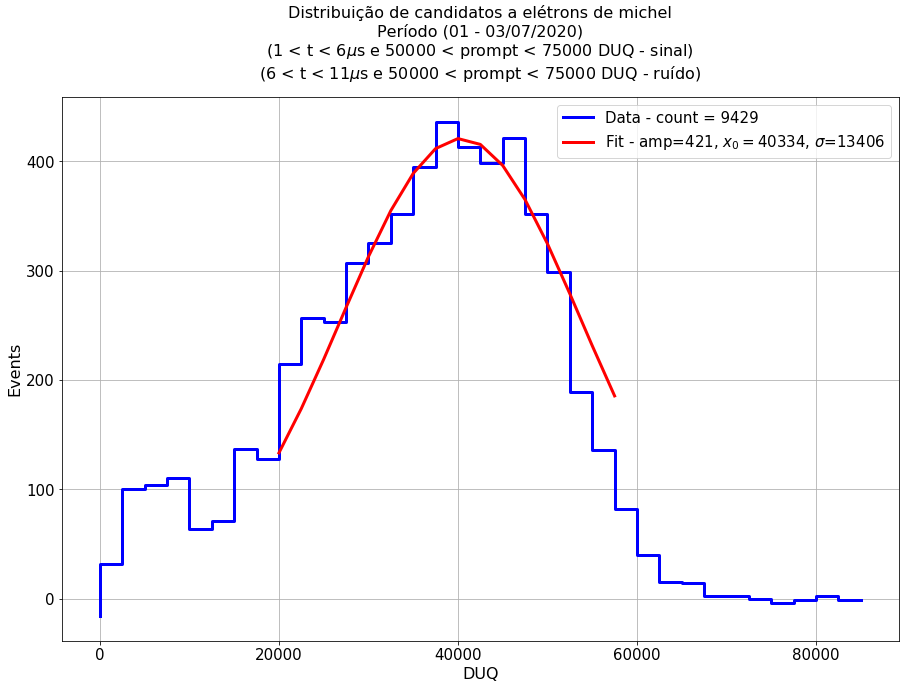

[ 32 100 104 110  64  71 137 128] [ 2500  5000  7500 10000 12500 15000 17500 20000] 746


[420.8879880377635, 40333.60461881085, 13405.84741570977, 746, 4615]

In [28]:
fnt_trace_fit_EM(h_PDD_Sgn, h_PDD_Bck,'(01 - 03/07/2020)','Hist_Michel_Sgn_72h_ind_0')

## Gaussian Params over the period

In [15]:
print('Início',datetime.datetime.now())

h_list_dtin, h_list_dtfn = load_DT('PD_Index_Michel_72h')

h_plot_params = []
h_list_dtp = []
h_list_amp = []
h_list_x0 = []
h_list_sigma = []
h_list_ev20kDUQ = []
h_list_ev20_60kDUQ = []

for ind in range(len(h_list_dtin)):
    #print(ind)
    s_ind = str(ind)
    h_PDP_Sgn=[]
    h_PDD_Sgn=[]
    h_PDT_Sgn=[]

    h_PDP_Sgn, h_PDD_Sgn, h_PDT_Sgn = load_PD ('PD_SGN_Michel_72h_ind_'+s_ind)  #Sinal
    #print(h_PDP_Sgn)

    h_PDP_Bck=[]
    h_PDD_Bck=[]
    h_PDT_Bck=[]

    h_PDP_Bck, h_PDD_Bck, h_PDT_Bck = load_PD ('PD_BCK_Michel_72h_ind_'+s_ind)  #ruido
    #print(h_PDP_Bck)

    h_plot_params.append(fnt_trace_fit_EM(h_PDD_Sgn, h_PDD_Bck,'('+h_list_dtin[ind]+' - '+h_list_dtfn[ind]+')','Hist_Michel_Sgn_72h_ind_'+s_ind, False))
    
    h_list_dtp.append(h_list_dtfn[ind])                ##período
    h_list_amp.append(h_plot_params[ind][0])           ##amplitude
    h_list_x0.append(h_plot_params[ind][1])            ##centro
    h_list_sigma.append(h_plot_params[ind][2])         ##largura
    h_list_ev20kDUQ.append(h_plot_params[ind][3])      ##eventos de baixa energia (<20kDUQ)
    h_list_ev20_60kDUQ.append(h_plot_params[ind][4])   ##eventos de alta energia (>20kDUQ e <60kDUQ)

#print(h_list_dtp)
#print(h_list_x0)

print('Fim',datetime.datetime.now())

Início 2024-11-05 23:47:05.406876
Fim 2024-11-05 23:47:10.079410


In [16]:
h_list_sigma_bak = []
h_list_sigma_bak.extend(h_list_sigma)

In [17]:
h_list_sigma.insert(29, float('nan'))  ##largura
h_list_sigma.insert(29, float('nan'))
h_list_sigma.insert(29, float('nan'))
h_list_sigma.insert(29, float('nan'))
print(h_list_sigma)


[13248.287742914436, 13001.071876713038, 13072.08506250299, 12891.536489945142, 13216.065339920882, 13218.779663389367, 13665.620593237583, 13630.329615199347, 13930.234296787668, 12665.787858221429, 13509.716421379375, 12941.767789148314, 14074.897080948916, 14268.646868042453, 13644.088669601982, 13334.027079761932, 13670.418410425453, 13844.267137317129, 13282.497525599865, 13394.6701831156, 13244.735708851691, 13115.041417959246, 13611.359894162919, 14151.15071486933, 13595.580777146182, 13744.467762075776, 13179.731320695575, 13928.673582557221, 13254.134962303582, nan, nan, nan, nan, 13837.573963517, 14681.132055546903, 14059.088695158289, 13202.420494154474, 14091.255639225545, 12979.622805595885, 14054.312294246183, 13873.678848134268, 14307.679723371386, 12784.779765853036, 13887.186781390892, 13898.860905961252, 14308.006086593861, 13096.942157113295, 12676.935176299648, 13167.341789666678, 14198.944672159065, 13592.016401153256, 14025.980266852484, 12630.269425018721, 13622.

In [18]:
h_list_x0_bak = []
h_list_x0_bak.extend(h_list_x0)
print(h_list_x0_bak)

[38078.1817472754, 38353.33552017584, 38112.31382944046, 38446.45470939704, 38548.90062200818, 37797.8048579106, 38555.04584736365, 39658.41288405556, 38158.8375630594, 38552.651300898084, 38457.78993419459, 38446.43814939133, 38028.20741139298, 38223.93203518593, 38699.35610863456, 38735.89309326995, 39052.479813788756, 38114.2770610184, 38164.91072103847, 38273.516389641976, 38848.66744446976, 38637.182736444716, 39182.8428653046, 39817.62211836541, 40069.14594986614, 41183.21795886446, 40488.4355945748, 39623.42304637313, 40602.62843160614, 41419.84678631817, 39454.388970571315, 38981.565028387035, 38825.443830268116, 41722.24741167488, 41186.39479362592, 40465.00694773757, 41518.00082171521, 38797.17664110325, 41160.55399774795, 39508.83920103371, 39522.60900925011, 40473.87526297735, 40865.455832511296, 41032.39976050894, 38722.71665420204, 41287.45493513606, 40878.10963445884, 39028.92614740859, 39951.29023935763, 39440.293372319546, 40332.52955899559, 41213.667504451914, 40077.6

In [19]:
h_list_x0.insert(29, float('nan'))   ##centro
h_list_x0.insert(29, float('nan'))
h_list_x0.insert(29, float('nan'))
h_list_x0.insert(29, float('nan'))
print(h_list_x0)

[38078.1817472754, 38353.33552017584, 38112.31382944046, 38446.45470939704, 38548.90062200818, 37797.8048579106, 38555.04584736365, 39658.41288405556, 38158.8375630594, 38552.651300898084, 38457.78993419459, 38446.43814939133, 38028.20741139298, 38223.93203518593, 38699.35610863456, 38735.89309326995, 39052.479813788756, 38114.2770610184, 38164.91072103847, 38273.516389641976, 38848.66744446976, 38637.182736444716, 39182.8428653046, 39817.62211836541, 40069.14594986614, 41183.21795886446, 40488.4355945748, 39623.42304637313, 40602.62843160614, nan, nan, nan, nan, 41419.84678631817, 39454.388970571315, 38981.565028387035, 38825.443830268116, 41722.24741167488, 41186.39479362592, 40465.00694773757, 41518.00082171521, 38797.17664110325, 41160.55399774795, 39508.83920103371, 39522.60900925011, 40473.87526297735, 40865.455832511296, 41032.39976050894, 38722.71665420204, 41287.45493513606, 40878.10963445884, 39028.92614740859, 39951.29023935763, 39440.293372319546, 40332.52955899559, 41213.6

In [20]:
h_list_amp_bak = []
h_list_amp_bak.extend(h_list_amp)

h_list_ev20kDUQ_bak = []
h_list_ev20kDUQ_bak.extend(h_list_ev20kDUQ)

h_list_ev20_60kDUQ_bak = []
h_list_ev20_60kDUQ_bak.extend(h_list_ev20_60kDUQ)

In [21]:
h_list_amp.insert(29, float('nan'))  
h_list_amp.insert(29, float('nan'))
h_list_amp.insert(29, float('nan'))
h_list_amp.insert(29, float('nan'))
print(h_list_amp)

h_list_ev20kDUQ.insert(29, float('nan'))  ##eventos de baixa energia (<20kDUQ)
h_list_ev20kDUQ.insert(29, float('nan'))
h_list_ev20kDUQ.insert(29, float('nan'))
h_list_ev20kDUQ.insert(29, float('nan'))
print(h_list_ev20kDUQ)

h_list_ev20_60kDUQ.insert(29, float('nan'))  ##eventos de alta energia (>20kDUQ e <60kDUQ)
h_list_ev20_60kDUQ.insert(29, float('nan'))
h_list_ev20_60kDUQ.insert(29, float('nan'))
h_list_ev20_60kDUQ.insert(29, float('nan'))
print(h_list_ev20_60kDUQ)

[425.0107557827037, 463.3593841907191, 460.30186287976426, 453.21045132040877, 465.15088910448935, 488.19845982898084, 462.6728624350837, 471.8058509484882, 449.1672409553824, 459.5171788376587, 455.16356842113044, 445.17840910268524, 471.8173695885706, 451.3688832443766, 465.61973590675495, 453.5071284124762, 456.71868520364455, 459.5097403850571, 455.57813323721126, 450.07393424164366, 455.9743724728928, 454.7729133464831, 441.9712623896974, 424.6047911780598, 437.2444486064502, 399.32643302802535, 414.9226638912507, 397.2266573922207, 421.1511549001224, nan, nan, nan, nan, 410.3639986752407, 415.47920642847305, 412.68032142544115, 437.32949351019727, 415.33516240969476, 428.72839424225594, 416.1371409209273, 417.48085926053125, 386.59765038324696, 431.2686715169393, 417.23899596277363, 435.91573860202936, 418.04511602920934, 442.3479877143404, 435.5026708175703, 442.29360885946903, 425.69362170288554, 434.91791113447863, 433.25742060690607, 445.91500350224777, 423.4922175433265, 431

In [22]:
print(h_list_dtp)

['2020-06-18', '2020-06-21', '2020-06-24', '2020-06-27', '2020-06-30', '2020-07-03', '2020-07-06', '2020-07-09', '2020-07-12', '2020-07-15', '2020-07-18', '2020-07-21', '2020-07-24', '2020-07-27', '2020-07-30', '2020-08-03', '2020-08-06', '2020-08-09', '2020-08-12', '2020-08-15', '2020-08-18', '2020-08-21', '2020-08-24', '2020-08-27', '2020-08-30', '2020-09-02', '2020-09-05', '2020-09-08', '2020-09-11', '2020-09-25', '2020-09-28', '2020-10-01', '2020-10-04', '2020-10-07', '2020-10-10', '2020-10-13', '2020-10-16', '2020-10-19', '2020-10-22', '2020-10-25', '2020-10-28', '2020-10-31', '2020-11-03', '2020-11-07', '2020-11-10', '2020-11-13', '2020-11-16', '2020-11-19', '2020-11-22', '2020-11-25', '2020-11-28', '2020-12-01', '2020-12-04', '2020-12-07', '2020-12-10', '2020-12-13', '2020-12-17', '2020-12-20', '2020-12-23', '2020-12-26', '2020-12-29']


In [23]:
#print(h_list_dtp)
#print(h_list_x0)

list_dtd_2 = []
list_dtd_2.extend(h_list_dtp)
list_dtd_2.insert(29, '2020-09-23')
list_dtd_2.insert(29, '2020-09-20')
list_dtd_2.insert(29, '2020-09-17')
list_dtd_2.insert(29, '2020-09-14')
print(list_dtd_2)
print(len(list_dtd_2))



['2020-06-18', '2020-06-21', '2020-06-24', '2020-06-27', '2020-06-30', '2020-07-03', '2020-07-06', '2020-07-09', '2020-07-12', '2020-07-15', '2020-07-18', '2020-07-21', '2020-07-24', '2020-07-27', '2020-07-30', '2020-08-03', '2020-08-06', '2020-08-09', '2020-08-12', '2020-08-15', '2020-08-18', '2020-08-21', '2020-08-24', '2020-08-27', '2020-08-30', '2020-09-02', '2020-09-05', '2020-09-08', '2020-09-11', '2020-09-14', '2020-09-17', '2020-09-20', '2020-09-23', '2020-09-25', '2020-09-28', '2020-10-01', '2020-10-04', '2020-10-07', '2020-10-10', '2020-10-13', '2020-10-16', '2020-10-19', '2020-10-22', '2020-10-25', '2020-10-28', '2020-10-31', '2020-11-03', '2020-11-07', '2020-11-10', '2020-11-13', '2020-11-16', '2020-11-19', '2020-11-22', '2020-11-25', '2020-11-28', '2020-12-01', '2020-12-04', '2020-12-07', '2020-12-10', '2020-12-13', '2020-12-17', '2020-12-20', '2020-12-23', '2020-12-26', '2020-12-29']
65


In [95]:
'''
list_dtd_2 = ['2020-06-23', '2020-06-26', '2020-06-29', '2020-07-02', '2020-07-05', '2020-07-08', '2020-07-11', 
              '2020-07-14', '2020-07-17', '2020-07-20', '2020-07-23', '2020-07-26', '2020-07-29', '2020-08-01', 
              '2020-08-04', '2020-08-07', '2020-08-10', '2020-08-13', '2020-08-16', '2020-08-19', '2020-08-22', 
              '2020-08-25', '2020-08-28', '2020-08-31', '2020-09-03', '2020-09-06', '2020-09-09', '2020-09-12', 
              '2020-09-15', '2020-09-18', '2020-09-21', '2020-09-24', '2020-09-27', '2020-09-30', '2020-10-03', 
              '2020-10-06', '2020-10-09', '2020-10-12', '2020-10-15', '2020-10-18', '2020-10-21', '2020-10-24', 
              '2020-10-27', '2020-10-30']
h_list_x0[28]=float('nan')
h_list_x0[29]=float('nan')
h_list_amp[28]=float('nan')
h_list_amp[29]=float('nan')
'''

## Variação do centro da gaussiana

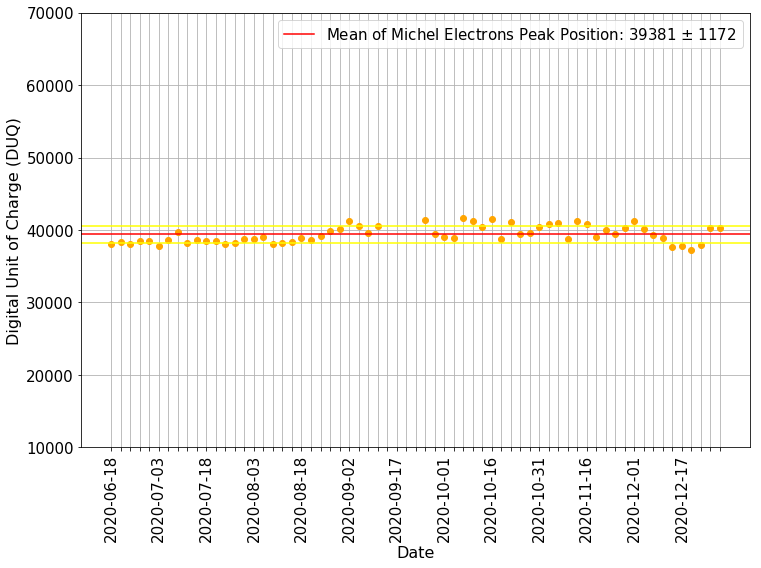

In [28]:

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

### xxx plt.plot(h_list_dtp, h_list_x0, 'bo', linewidth=3) #, label='centro')
plt.plot(list_dtd_2, h_list_x0, color='orange', marker='o', linewidth=0) #, label='centro')

#errbar_sigma_day = []
#for inf in range(len(h_list_x0)):
#    errbar_sigma_day.append((h_list_x0[inf])**0.5)

#plt.errorbar(list_dtd_2, h_list_x0, yerr=errbar_sigma_day, #[1:] , 
#                marker='o', color='blue', 
#                linestyle='None', capsize=4, label='dado')


list_dtd_lab = []
for i in range(len(list_dtd_2)):
    if (i % 5 == 0):
        list_dtd_lab.append(list_dtd_2[i])
    else:
        list_dtd_lab.append('')
        
list_mean_amp = []

for j in range(len(h_list_x0)):
    if (h_list_x0[j]>100):
        list_mean_amp.append(h_list_x0[j])
        
plt.axhline(np.mean(list_mean_amp)+np.std(list_mean_amp),color='yellow')
plt.axhline(np.mean(list_mean_amp),color='red',
            label='Mean of Michel Electrons Peak Position: {:.0f} $\pm$ {:.0f}'.format(np.mean(list_mean_amp),np.std(list_mean_amp)))
plt.axhline(np.mean(list_mean_amp)-np.std(list_mean_amp),color='yellow')


plt.ylim(10000,70000)

plt.ylabel('Digital Unit of Charge (DUQ)', size=16)
plt.xlabel('Date', size=16)
plt.xticks(list_dtd_2, list_dtd_lab, rotation=90)
plt.legend(loc="upper right")
plt.grid()

#plt.title('Centro das Gaussianas de candidatos a elétrons de michel ao longo do período\n', size=16,y=1.02)
#plt.title('Gaussian Center of then Michel Electrons candidates\n', size=16,y=1.02)

plt.savefig('histogramas/Params_Centro_Gauss_EM.png')
plt.show()




## Variação da largura da gaussiana

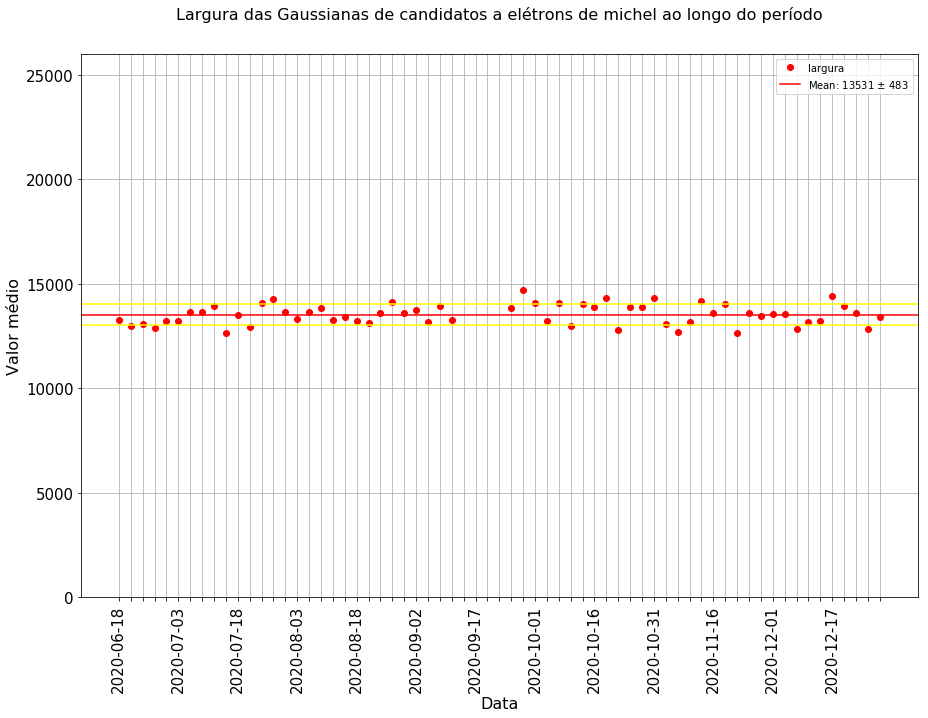

In [36]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

#plt.plot(h_list_dtp, h_list_sigma, 'ro', linewidth=3, label='largura')
plt.plot(list_dtd_2, h_list_sigma, 'ro', linewidth=3, label='largura')

#plt.plot(list_dtd_2, h_list_amp, 'go', linewidth=3) #, label='amplitude')


list_dtd_lab = []
for i in range(len(list_dtd_2)):
    if (i % 5 == 0):
        list_dtd_lab.append(list_dtd_2[i])
    else:
        list_dtd_lab.append('')
        
plt.ylim(0,750)

list_mean_sigma = []

for j in range(len(h_list_sigma)):
    if (h_list_sigma[j]>100):
        list_mean_sigma.append(h_list_sigma[j])
        
plt.axhline(np.mean(list_mean_sigma)+np.std(list_mean_sigma),color='yellow')
plt.axhline(np.mean(list_mean_sigma),color='red',
            label='Mean: {:.0f} $\pm$ {:.0f}'.format(np.mean(list_mean_sigma),np.std(list_mean_sigma)))
plt.axhline(np.mean(list_mean_sigma)-np.std(list_mean_sigma),color='yellow')

plt.ylim(0,26000)

plt.ylabel('Valor médio', size=16)
plt.xlabel('Data', size=16)
plt.xticks(list_dtd_2, list_dtd_lab, rotation=90)
plt.legend(loc="upper right")
plt.grid()

plt.title('Largura das Gaussianas de candidatos a elétrons de michel ao longo do período\n', size=16,y=1.02)

plt.savefig('histogramas/Params_Larg_Gauss_EM_all.png')
plt.show()


## Variação da amplitude da gaussiana

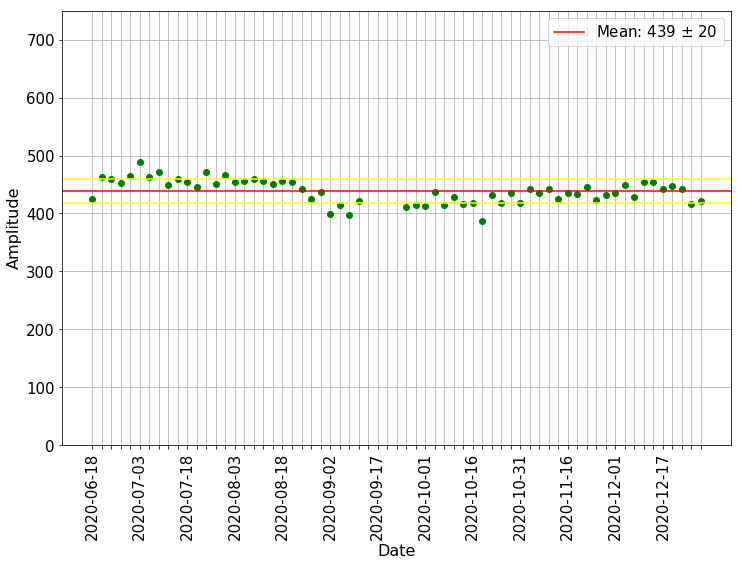

In [40]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

#plt.plot(h_list_dtp, h_list_sigma, 'go', linewidth=3, label='largura')
plt.plot(list_dtd_2, h_list_amp, 'go', linewidth=3) #, label='amplitude')


list_dtd_lab = []
for i in range(len(list_dtd_2)):
    if (i % 5 == 0):
        list_dtd_lab.append(list_dtd_2[i])
    else:
        list_dtd_lab.append('')
        
plt.ylim(0,750)

list_mean_amp = []

for j in range(len(h_list_amp)):
    if (h_list_amp[j]>100):
        list_mean_amp.append(h_list_amp[j])
        
plt.axhline(np.mean(list_mean_amp)+np.std(list_mean_amp),color='yellow')
plt.axhline(np.mean(list_mean_amp),color='red',
            label='Mean: {:.0f} $\pm$ {:.0f}'.format(np.mean(list_mean_amp),np.std(list_mean_amp)))
plt.axhline(np.mean(list_mean_amp)-np.std(list_mean_amp),color='yellow')

plt.ylabel('Amplitude', size=16)
plt.xlabel('Date', size=16)
plt.xticks(list_dtd_2, list_dtd_lab, rotation=90)
plt.legend(loc="upper right")
plt.grid()

#plt.title('Amplitude das Gaussianas de candidatos a elétrons de michel ao longo do período\n', size=16,y=1.02)

plt.savefig('histogramas/Params_Ampl_Gauss_EM_all.png')
plt.show()


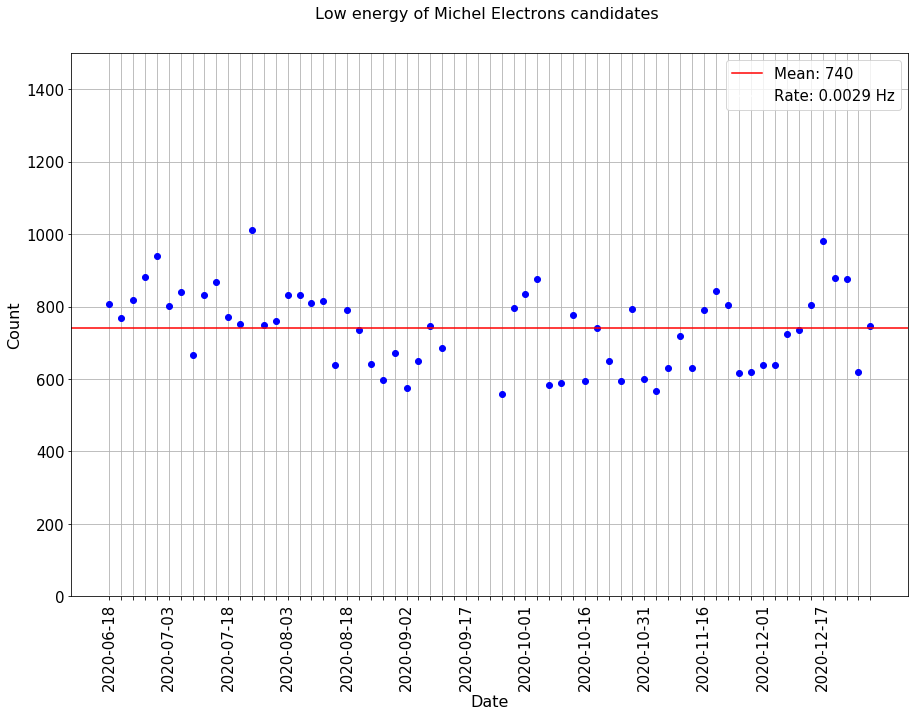

In [36]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

plt.plot(list_dtd_2, h_list_ev20kDUQ, 'bo', linewidth=3) #, label='Soma de eventos até 20KDUQ')

list_dtd_lab = []
for i in range(len(list_dtd_2)):
    if (i % 5 == 0):
        list_dtd_lab.append(list_dtd_2[i])
    else:
        list_dtd_lab.append('')

plt.ylim(0,1500)

#plt.axhline(np.mean(h_list_ev20kDUQ),color='red',
#            label='Mean: {:.0f} $\pm$ {:.0f}'.format(np.mean(h_list_ev20kDUQ),np.std(h_list_ev20kDUQ)))


list_mean_em = []

for j in range(len(h_list_ev20kDUQ)):
    if (h_list_ev20kDUQ[j]>100):
        list_mean_em.append(h_list_ev20kDUQ[j])

EM_rate = round(np.mean(list_mean_em)/72/60/60,4)

plt.axhline(np.mean(list_mean_em),color='red',
            label='Mean: {:.0f}'.format(np.mean(list_mean_em)))
plt.axhline(EM_rate,color='white',label='Rate: {:.4f} Hz'.format(EM_rate))

plt.ylabel('Count', size=16)
plt.xlabel('Date', size=16)
plt.xticks(list_dtd_2, list_dtd_lab, rotation=90)
plt.legend(loc="upper right")
plt.grid()

#plt.title('Eventos até 20KDUQ ao longo do período\n', size=16,y=1.02)
plt.title('Low energy of Michel Electrons candidates \n', size=16,y=1.02)

plt.savefig('histogramas/Params_ev20KDUQ_all.png')
plt.show()


## Média de eventos  / frequência de eventos de elétrons de Michel

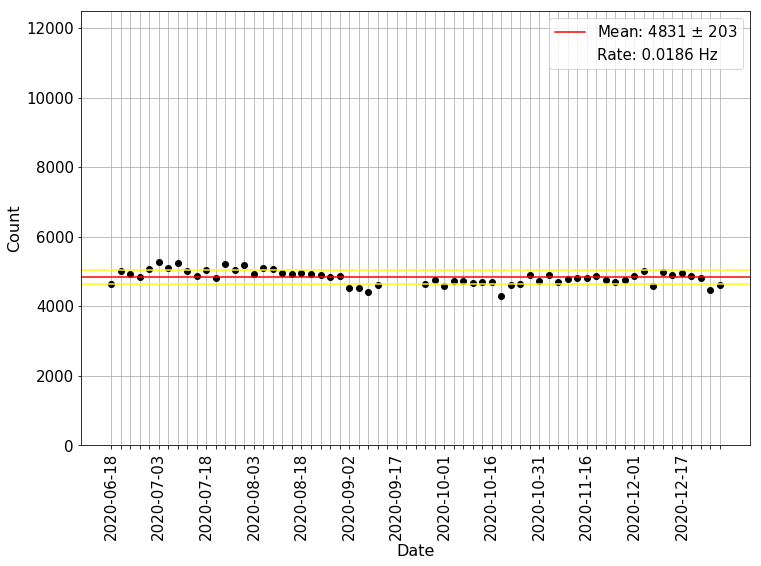

Freq EM:  0.0186 Hz
Freq eventos: 190 Hz
Razao EM / eventos:  0.0098 %


In [34]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

plt.plot(list_dtd_2, h_list_ev20_60kDUQ, 'ko', linewidth=3) #, label='Soma de eventos de 20KDUQ a 60KDUQ')

list_dtd_lab = []
for i in range(len(list_dtd_2)):
    if (i % 5 == 0):
        list_dtd_lab.append(list_dtd_2[i])
    else:
        list_dtd_lab.append('')
        
plt.ylim(0,12500)

list_mean_em = []

for j in range(len(h_list_ev20_60kDUQ)):
    if (h_list_ev20_60kDUQ[j]>100):
        list_mean_em.append(h_list_ev20_60kDUQ[j])

EM_rate = round(np.mean(list_mean_em)/72/60/60,4)

#plt.axhline(np.mean(list_mean_em),color='red',
#            label='Mean: {:.0f} $\pm$ {:.0f}'.format(np.mean(list_mean_em),np.std(list_mean_em)))

plt.axhline(np.mean(list_mean_em)+np.std(list_mean_em),color='yellow')
plt.axhline(np.mean(list_mean_em),color='red',
            label='Mean: {:.0f} $\pm$ {:.0f}'.format(np.mean(list_mean_em),np.std(list_mean_em)))
plt.axhline(np.mean(list_mean_em)-np.std(list_mean_em),color='yellow')

plt.axhline(EM_rate,color='white',label='Rate: {:.4f} Hz'.format(EM_rate))
#plt.axhline(EM_rate,color='white',label='Ratio EM / Trigger: {:.4f} %'.format(EM_rate/189.7*100))

plt.ylabel('Count', size=16)
plt.xlabel('Date', size=16)
plt.xticks(list_dtd_2, list_dtd_lab, rotation=90)
plt.legend(loc="upper right")
plt.grid()

#plt.title('Count of Electrons Michel candidates (06/23/2020 - 10/30/2020)\n', size=16,y=1.02)

plt.savefig('histogramas/Params_ev20_60KDUQ.png')
plt.show()

print('Freq EM: ',round(np.mean(list_mean_em)/72/60/60,4),'Hz')
print('Freq eventos: 190 Hz')
print('Razao EM / eventos: ',round((round(np.mean(list_mean_em)/72/60/60,4)/190)*100,4),'%')

In [ ]:
h_PDP_Sgn=[]
h_PDD_Sgn=[]
h_PDT_Sgn=[]

h_PDP_Sgn, h_PDD_Sgn, h_PDT_Sgn = load_PD ('PD_SGN_Michel_72h_ind_0')  #Sinal

print(h_PDP_Sgn)

h_PDP_Bck=[]
h_PDD_Bck=[]
h_PDT_Bck=[]

h_PDP_Bck, h_PDD_Bck, h_PDT_Bck = load_PD ('PD_BCK_Michel_72h_ind_0')  #Sinal

print(h_PDP_Bck)

fnt_trace_fit_EM(h_PDD_Sgn, h_PDD_Bck,'(01 - 03/07/2020)','Hist_Michel_Sgn_72h_ind_0')

## Gaussians

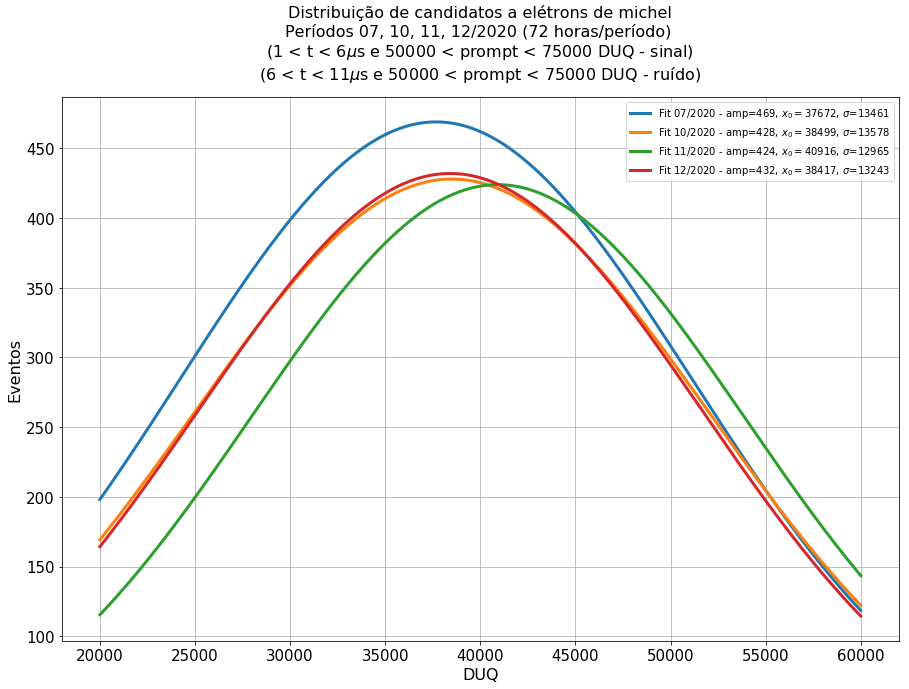

In [37]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

xh_data = np.linspace(20000, 60000, num=40000)

params_h = [469, 37672, 13461] 
plt.plot(xh_data, fnt_fit_gauss_2(xh_data, params_h[0], params_h[1], params_h[2]), 
         label='Fit 07/2020 - amp={:0.0f}, $x_0=${:0.0f}, $\sigma$={:0.0f}'.format(params_h[0], params_h[1], params_h[2]), linewidth=3)

params_h = [428, 38499, 13578] 
plt.plot(xh_data, fnt_fit_gauss_2(xh_data, params_h[0], params_h[1], params_h[2]), 
         label='Fit 10/2020 - amp={:0.0f}, $x_0=${:0.0f}, $\sigma$={:0.0f}'.format(params_h[0], params_h[1], params_h[2]), linewidth=3)

params_h = [424, 40916, 12965] 
plt.plot(xh_data, fnt_fit_gauss_2(xh_data, params_h[0], params_h[1], params_h[2]), 
         label='Fit 11/2020 - amp={:0.0f}, $x_0=${:0.0f}, $\sigma$={:0.0f}'.format(params_h[0], params_h[1], params_h[2]), linewidth=3)

params_h = [432, 38417, 13243] 
plt.plot(xh_data, fnt_fit_gauss_2(xh_data, params_h[0], params_h[1], params_h[2]), 
         label='Fit 12/2020 - amp={:0.0f}, $x_0=${:0.0f}, $\sigma$={:0.0f}'.format(params_h[0], params_h[1], params_h[2]), linewidth=3)

plt.ylabel('Eventos', size=16)
plt.xlabel('DUQ', size=16)
plt.legend(loc="upper right")
plt.grid()

plt.title('Distribuição de candidatos a elétrons de michel\n'+
          'Períodos 07, 10, 11, 12/2020 (72 horas/período) \n'+
          '(1 < t < 6$\mu$s e 50000 < prompt < 75000 DUQ - sinal)\n'+
          '(6 < t < 11$\mu$s e 50000 < prompt < 75000 DUQ - ruído)'
          , size=16,y=1.02)


plt.savefig('histogramas/Gauss_Michel_2020_commis.png')
plt.show()
